In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D, Dense
from tensorflow.keras import layers
import keras.backend as K
import sys

np.set_printoptions(threshold=sys.maxsize)
gpus = tf.config.experimental.list_physical_devices('XLA_GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'XLA_GPU')

In [2]:
ResNext_model = tf.keras.models.load_model('ResNext_models/')
NasNet_model = tf.keras.models.load_model('NasNet_models/')

In [3]:
ResNext_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 11, 11, 2048)      58331648  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 14343     
Total params: 58,345,991
Trainable params: 58,202,247
Non-trainable params: 143,744
_________________________________________________________________


In [4]:
NasNet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d (Gl (None, 4032)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 28231     
Total params: 84,945,049
Trainable params: 84,748,381
Non-trainable params: 196,668
_________________________________________________________________


In [5]:
X_test = np.load('./data/pre_ok_data/test.npy')
y_test = np.load('./data/pre_ok_data/s_label.npy')

In [6]:
from keras.utils import to_categorical

X_test = X_test.astype('float32') / 255
y_test = to_categorical(y_test)

In [7]:
print('X_test : ', X_test.shape, 'y_test : ', y_test.shape)

X_test :  (3557, 331, 331, 3) y_test :  (3557, 7)


In [8]:
models = [ResNext_model, NasNet_model]

yhats = [model.predict(X_test) for model in models]
yhats = np.array(yhats)

summed = np.sum(yhats, axis=0)

outcomes = np.argmax(summed, axis=1)

In [9]:
outcomes.shape

(3557,)

In [10]:
real_label = np.argmax(y_test, axis = 1)

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(real_label, outcomes)

classes = ['1', '2', '3', '4', '5', '6', '7']

for i in range(len(cf)):
    print(classes[i], ' class confusion matrix : ', cf[i])

1  class confusion matrix :  [442  14  43  36  75  18   8]
2  class confusion matrix :  [  7 876   7   0   4   3   3]
3  class confusion matrix :  [ 21   2 431  17  19  10   3]
4  class confusion matrix :  [ 36   4  59 241  34  11   1]
5  class confusion matrix :  [ 96  21  69  51 363  17   9]
6  class confusion matrix :  [  4   1   6  10  11 190   2]
7  class confusion matrix :  [  1   2   9   0   1   2 267]


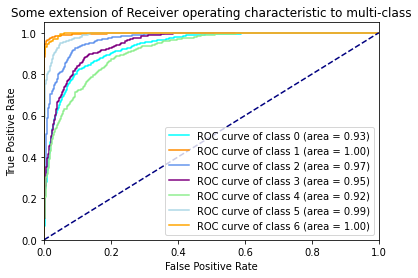

In [14]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], summed[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], summed[:, i])




# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', "purple", "lightgreen", "lightblue", "orange"])
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i],
             color=color, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1],
         color='navy', linestyle='--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [15]:
from sklearn.metrics import classification_report

print(classification_report(real_label, outcomes))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       636
           1       0.95      0.97      0.96       900
           2       0.69      0.86      0.76       503
           3       0.68      0.62      0.65       386
           4       0.72      0.58      0.64       626
           5       0.76      0.85      0.80       224
           6       0.91      0.95      0.93       282

    accuracy                           0.79      3557
   macro avg       0.78      0.79      0.78      3557
weighted avg       0.79      0.79      0.79      3557

